# Finite-Element Mode Solver

Using femwell, you can mesh any component cross-section and solve PDEs with its powerful mode solver.

Unlike other solvers that rely on predefined geometries, femwell works directly with the actual component geometry. You can compute the modes of a GDSFactory cross-section, which internally defines a "uz" mesh perpendicular to a straight component using the provided cross-section.

Additionally, you can downsample layers from the LayerStack and modify both the cross-section and LayerStack before running the simulation to adjust the geometry. You can also define refractive indices based on the active PDK.

In [ ]:
import logging
import sys

try:
    from femwell.maxwell.waveguide import compute_modes
    from femwell.visualization import plot_domains
    from skfem import Basis, ElementTriP0
    from skfem.io.meshio import from_meshio
except ImportError:
    raise ImportError("Please install pytools-litho-design with the femwell option")


import gdsfactory as gf
import matplotlib.pyplot as plt
from gdsfactory.generic_tech import LAYER_STACK, get_generic_pdk
from gdsfactory.technology import LayerStack
from gplugins.gmsh import get_mesh
from rich.logging import RichHandler


gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

First we choose a component to simulate. Here, a straight strip waveguide:

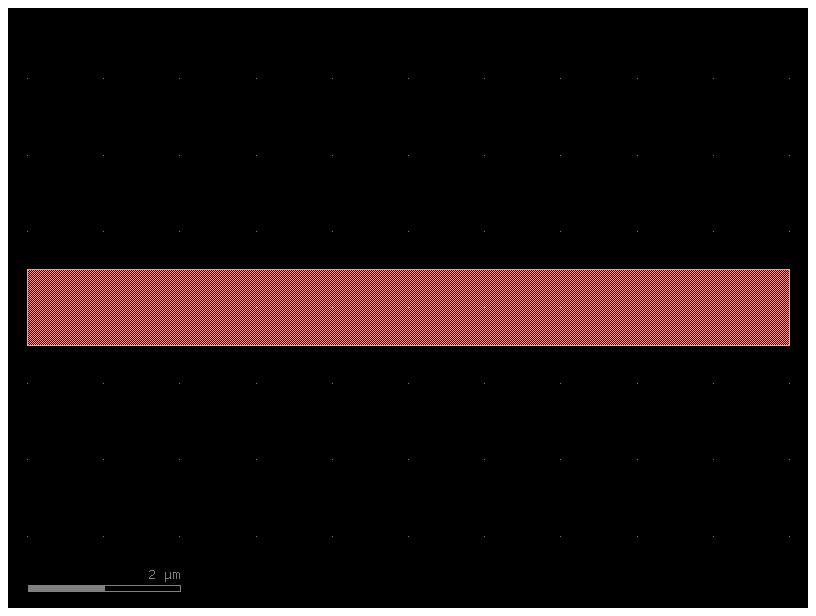

In [2]:
xs = gf.cross_section.strip(width=1)

c = gf.components.straight(cross_section=xs)
c

Then we choose a Layer Stack. Here, we simply downsample the generic stack:

In [3]:
filtered_layer_stack = LayerStack(
    layers={
        k: LAYER_STACK.layers[k]
        for k in (
            "core",
            "clad",
            "slab90",
            "box",
        )
    }
)

We can also change some of the values:

In [4]:
filtered_layer_stack.layers[
    "core"
].thickness = 0.22  # Perturb the layer_stack before simulating

filtered_layer_stack.layers[
    "slab90"
].thickness = 0.09  # Perturb the layer_stack before simulating

# When selecting resolutions, the names must match the keys of the layerstack
# Here, choose a finer mesh inside and close to the core
resolutions = {
    "core": {"resolution": 0.02, "DistMax": 2, "SizeMax": 0.2},
}

Using gplugins, we quickly generate a cross-sectional mesh:

In [5]:
mesh_gmsh = get_mesh(
    component=c,
    layer_stack=filtered_layer_stack,
    type="uz",  # we want a cross-section
    xsection_bounds=((1, -3), (1, 3)),  # the line from which we take a cross-section
    wafer_padding=3,  # pad simulation domain 3 microns around the component
    filename="mesh.msh",
    # resolutions=resolutions,
    default_characteristic_length=0.5,
)

TypeError: PolySurface.__init__() got an unexpected keyword argument 'resolution'

We can now throw this mesh into FEMWELL directly:

In [ ]:
mesh = from_meshio(mesh_gmsh)
mesh.draw().show()

plot_domains(mesh)
plt.show()

Assign material values

In [ ]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 3.45, "box": 1.444, "clad": 1.444}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

Solve for the modes:

In [ ]:
wavelength = 1.55
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=1)

You can use them as inputs to other [femwell mode solver functions](https://github.com/HelgeGehring/femwell/blob/main/femwell/mode_solver.py) to inspect or analyze the modes:

In [ ]:
print(modes[0].te_fraction)

In [ ]:
modes[0].show("E", part="real")

In [ ]:
dir(modes[0])

In [ ]:
modes[0].plot_component?

In [ ]:
modes[0].plot_component("E", component="x", part="real", colorbar=True)

In [ ]:
modes[1].plot_component("E", component="x", part="real", colorbar=True)

In [ ]:
modes[1].show("E", part="real")